# Validate the nonspecific bead interaction contribution to the field energy

### Navigate to root directory

In [1]:
# Built-in modules
import os
import sys

# Insert package root to system path
cwd = os.getcwd()
parent_dir = cwd + "/../.."
sys.path.insert(1, parent_dir)

print("Directory containing the notebook:")
print(cwd)

Directory containing the notebook:
/home/users/jwakim/CodeDev/chromo_check_density_calculation/doc/tools


In [2]:
# Change working directory to package root
os.chdir(parent_dir)
print("Root Directory of Package: ")
print(os.getcwd())

Root Directory of Package: 
/home/users/jwakim/CodeDev/chromo_check_density_calculation


### Import modules

In [3]:
# External modules
import numpy as np
import matplotlib.pyplot as plt

# Package modules
from chromo.polymers import SSWLC
import chromo.binders
from chromo.fields import UniformDensityField

### Specify reader proteins

In [4]:
hp1 = chromo.binders.get_by_name("HP1")
binders = chromo.binders.make_binder_collection([hp1])

### Specify confinement

In [5]:
bead_vol = 520
bead_rad = np.cbrt(bead_vol / (4/3 * np.pi))

confine_type = "Cubical"
voxel_count = 1
voxel_size = 28.7
voxel_vol = voxel_size**3

n_beads_arr = np.arange(1, int(np.ceil(0.5 * voxel_vol / bead_vol + 1)) + 1, 1, dtype=int)

reader = chromo.binders.get_by_name("null_reader")
binders = chromo.binders.make_binder_collection([reader])

chi = 1

### Initialize polymer and field

In [6]:
%%capture

udfs = []
polymers = []
out_dirs = []
delta = 50

for i, n_beads in enumerate(n_beads_arr):

    # Instantiate Polymer
    chemical_mods = np.atleast_2d(np.ones(n_beads, dtype=int)).T
    states = chemical_mods.copy()
    r = np.ones((n_beads, 3), dtype=float) * voxel_size/2
    t3 = np.zeros((n_beads, 3), dtype=float)
    t2 = np.zeros((n_beads, 3), dtype=float)
    poly = SSWLC(
        name = "polymer",
        r = r,
        bead_length = 1,
        lp = 0.1,
        bead_rad = bead_rad,
        t3 = t3,
        t2 = t2,
        states = states,
        binder_names=np.array(['null_reader']),
        chemical_mods=chemical_mods,
        chemical_mod_names=np.array(['null_mods'])
    )
    polymers.append(poly)

    # Instantiate Field
    n_bins_x = 1
    n_bins_y = 1
    n_bins_z = 1
    x_width = voxel_size
    y_width = voxel_size
    z_width = voxel_size
    udf = UniformDensityField(
        polymers = [poly],
        binders = binders,
        x_width = x_width,
        nx = n_bins_x,
        y_width = y_width,
        ny = n_bins_y,
        z_width = z_width,
        nz = n_bins_z,
        confine_type = confine_type,
        confine_length = voxel_size,
        chi = chi
    )
    udfs.append(udf)

### Calculate nonspecific interaction energy

In [7]:
nonspecific_Es = []
nonspecific_Es_theory = []

for i, n_beads in enumerate(n_beads_arr):
    nonspecific_Es.append(udfs[i].nonspecific_interact_E(polymers[i]))

    if n_beads > 0.5 * voxel_vol / bead_vol:
        nonspecific_Es_theory.append(1E99)
    else:
        nonspecific_Es_theory.append(chi * voxel_vol * (n_beads * bead_vol / voxel_vol)**2)

nonspecific_Es = np.array(nonspecific_Es)
nonspecific_Es_theory = np.array(nonspecific_Es_theory)

print("Num Beads:")
print(n_beads_arr)
print("Nonspecific Interaction Energy from Simulation (kT):")
print(nonspecific_Es)
print("Nonspecific Interaction Energy from Theory (kT):")
print(nonspecific_Es_theory)

Num Beads:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Nonspecific Interaction Energy from Simulation (kT):
[1.14382872e+01 4.57531488e+01 1.02944585e+02 1.83012595e+02
 2.85957180e+02 4.11778339e+02 5.60476073e+02 7.32050381e+02
 9.26501264e+02 1.14382872e+03 1.38403275e+03 1.64711336e+03
 1.93307054e+03 2.24190429e+03 2.57361462e+03 2.92820152e+03
 3.30566500e+03 3.70600505e+03 4.12922168e+03 4.57531488e+03
 5.04428466e+03 5.53613101e+03 1.00000000e+99 1.00000000e+99]
Nonspecific Interaction Energy from Theory (kT):
[1.14382872e+01 4.57531488e+01 1.02944585e+02 1.83012595e+02
 2.85957180e+02 4.11778339e+02 5.60476073e+02 7.32050381e+02
 9.26501264e+02 1.14382872e+03 1.38403275e+03 1.64711336e+03
 1.93307054e+03 2.24190429e+03 2.57361462e+03 2.92820152e+03
 3.30566500e+03 3.70600505e+03 4.12922168e+03 4.57531488e+03
 5.04428466e+03 5.53613101e+03 1.00000000e+99 1.00000000e+99]


### Plot nonspecific interaction energies

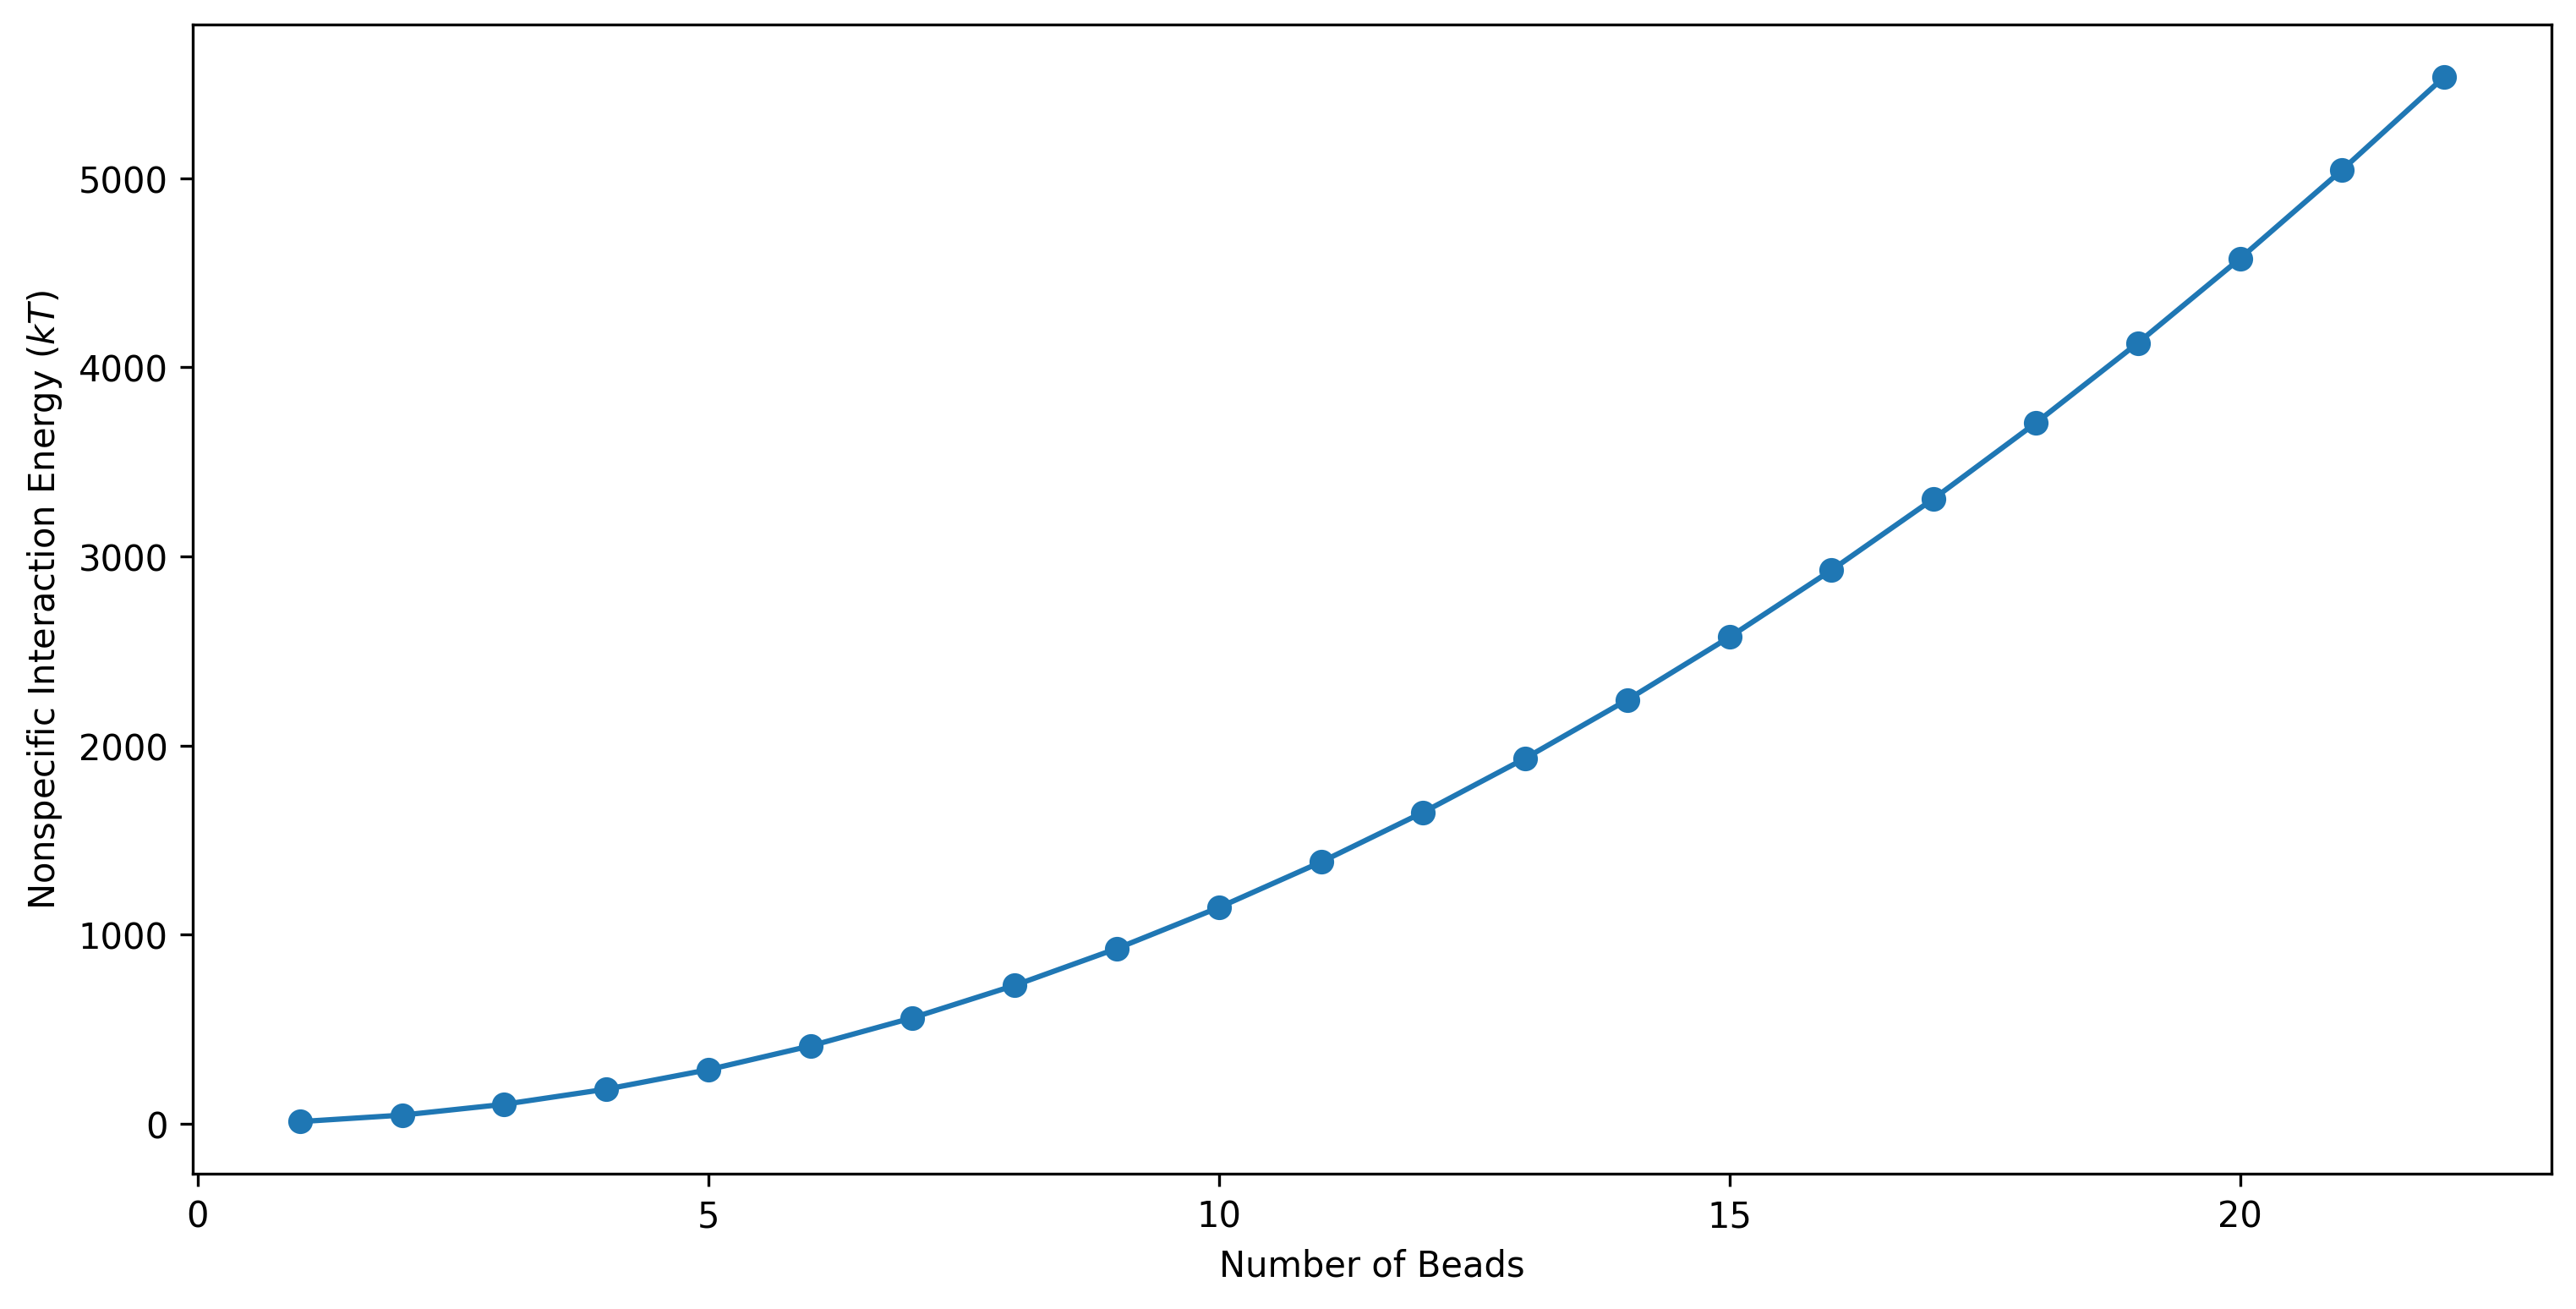

In [8]:
ind_end = len(n_beads_arr) - 2

plt.figure(figsize=(12,6), dpi=300)
plt.scatter(n_beads_arr[:ind_end], nonspecific_Es[:ind_end])
plt.plot(n_beads_arr[:ind_end], nonspecific_Es_theory[:ind_end])
plt.xlabel(r"Number of Beads")
plt.ylabel(r"Nonspecific Interaction Energy ($kT$)")
plt.show()